🚀 Training Stacking Ensemble (LGBM + LogReg -> KNN)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/02/16 19:00:21 INFO mlflow.tracking.fluent: Experiment with name 'EXP 9 - Ensemble Stacking (Clean Text)' does not exist. Creating a new experiment.



📊 Final Ensemble Report:
              precision    recall  f1-score   support

          -1       0.79      0.73      0.76      1650
           0       0.87      0.94      0.90      2529
           1       0.88      0.86      0.87      3154

    accuracy                           0.86      7333
   macro avg       0.85      0.84      0.84      7333
weighted avg       0.86      0.86      0.86      7333



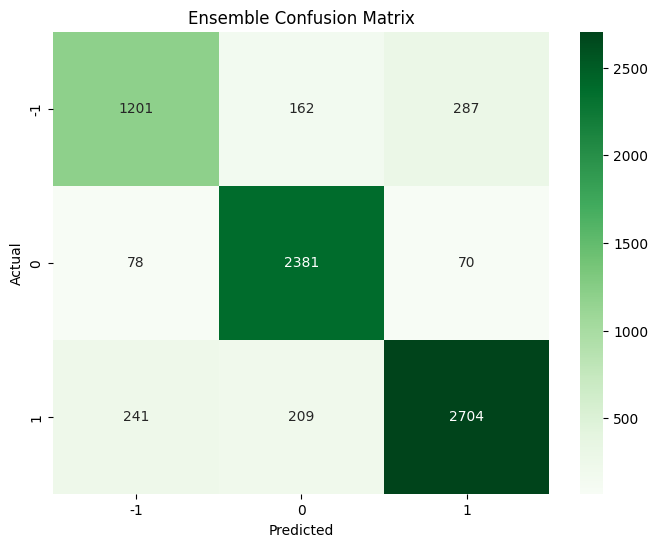

🏃 View run Stacking_CleanText_Features at: https://dagshub.com/Ritk-Raikwar/reddit-comment-sentiment-analysis.mlflow/#/experiments/8/runs/ac52885eaddd411ea7d7b78c7be9e4c1
🧪 View experiment at: https://dagshub.com/Ritk-Raikwar/reddit-comment-sentiment-analysis.mlflow/#/experiments/8
✅ Experiment Complete.


In [5]:
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier

# Imbalanced-learn libraries for ADASYN
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# --- 1. Load Data ---
try:
    df = pd.read_csv('reddit_preprocessed.csv')
    df = df.drop('Unnamed: 0', axis=1, errors='ignore')
    df = df.dropna()
    df['clean_comment'] = df['clean_comment'].astype(str)
except FileNotFoundError:
    print("❌ Upload dataset first.")
    raise

# Encode Labels
le = LabelEncoder()
y = le.fit_transform(df['category'])
class_names = [str(cls) for cls in le.classes_]

# Split Data (Stratified to maintain imbalance in test set)
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Define Custom Feature Extractor (Clean Text Version) ---
class CleanTextMetadataExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Expecting X to be a pandas Series of text
        features = pd.DataFrame(index=X.index)

        # Helper: Calculate word list once per row to speed up
        # We assume text is already lowercase and stripped of punctuation
        word_lists = X.str.split()

        # 1. Word Count (Length)
        features['word_count'] = word_lists.str.len()

        # 2. Unique Word Ratio (Vocabulary Richness)
        # Avoid division by zero with .replace(0, 1) or max(1) logic
        features['unique_ratio'] = word_lists.apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

        # 3. Average Word Length (Complexity)
        features['avg_word_len'] = word_lists.apply(
            lambda x: np.mean([len(w) for w in x]) if len(x) > 0 else 0
        )

        # 4. Stopword Ratio (Density of content)
        # How many words are generic "the", "is", "at"?
        stop_words = set(ENGLISH_STOP_WORDS)
        features['stopword_ratio'] = word_lists.apply(
            lambda x: sum(1 for w in x if w in stop_words) / len(x) if len(x) > 0 else 0
        )

        return features.fillna(0)

# --- 3. Define Processing Pipelines ---

# Branch A: TF-IDF (N-grams are crucial for clean text to catch "not good")
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Branch B: Custom Metadata Features (Scaled)
metadata_transformer = SklearnPipeline([
    ('extractor', CleanTextMetadataExtractor()),
    ('scaler', StandardScaler())
])

# Combine A & B
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', text_transformer, 'clean_comment'),
        ('meta', metadata_transformer, 'clean_comment')
    ],
    remainder='drop'
)

# Convert to DataFrame for ColumnTransformer compatibility
X_train_df = pd.DataFrame(X_train, columns=['clean_comment'])
X_test_df = pd.DataFrame(X_test, columns=['clean_comment'])


# --- 4. Define Base Learners ---

# Model 1: LightGBM (Internal Imbalance Handling)
# LightGBM is great at using the dense metadata features along with sparse text
lgbm_pipeline = SklearnPipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(
        n_estimators=200,
        class_weight='balanced', # Internal handling
        objective='multiclass',
        random_state=42,
        verbose=-1
    ))
])

# Model 2: Logistic Regression (External ADASYN Handling)
# ADASYN works well here because the "metadata" features help separate classes in space
logreg_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', ADASYN(random_state=42, sampling_strategy='minority')), # External handling
    ('clf', LogisticRegression(max_iter=1000, class_weight=None))
])


# --- 5. Define Meta Learner (Stacking) ---

# KNN will look at the probabilities from LGBM and LogReg and "vote" based on neighbors
stacking_clf = StackingClassifier(
    estimators=[
        ('lightgbm', lgbm_pipeline),
        ('logreg_adasyn', logreg_pipeline)
    ],
    final_estimator=KNeighborsClassifier(n_neighbors=5, weights='distance'),
    cv=3,
    n_jobs=-1
)

# --- 6. Train & Evaluate ---

print("🚀 Training Stacking Ensemble (LGBM + LogReg -> KNN)...")
stacking_clf.fit(X_train_df, y_train)
y_pred = stacking_clf.predict(X_test_df)

# --- 7. Logging & Results ---
mlflow.set_experiment("EXP 9 - Ensemble Stacking (Clean Text)")

with mlflow.start_run(run_name="Stacking_CleanText_Features"):

    # Log configuration
    mlflow.log_param("model_type", "StackingClassifier")
    mlflow.log_param("base_1", "LightGBM (balanced)")
    mlflow.log_param("base_2", "LogReg (ADASYN)")
    mlflow.log_param("meta", "KNN")
    mlflow.log_param("features", "WordCount, UniqueRatio, StopwordRatio")

    # Metrics
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print("\n📊 Final Ensemble Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    mlflow.log_metric("accuracy", report['accuracy'])
    mlflow.log_metric("macro_f1", report['macro avg']['f1-score'])

    # Log Class Metrics
    for label in class_names:
        if label in report:
            safe_lbl = label.replace("-", "neg")
            mlflow.log_metric(f"{safe_lbl}_recall", report[label]['recall'])
            mlflow.log_metric(f"{safe_lbl}_f1", report[label]['f1-score'])

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title("Ensemble Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("ensemble_cm.png")
    mlflow.log_artifact("ensemble_cm.png")
    plt.show()

print("✅ Experiment Complete.")

In [3]:
!pip install mlflow dagshub optuna lightgbm imbalanced-learn kaleido

In [4]:
import dagshub
dagshub.init(repo_owner='Ritk-Raikwar', repo_name='reddit-comment-sentiment-analysis', mlflow=True)

⠴ Waiting for authorization

Accessing as Ritk-Raikwar

Initialized MLflow to track repo "Ritk-Raikwar/reddit-comment-sentiment-analysis"

Repository Ritk-Raikwar/reddit-comment-sentiment-analysis initialized!

In [8]:
import pandas as pd
import numpy as np
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# --- 1. Load & Process Data ---
try:
    df = pd.read_csv('reddit_preprocessed.csv')
    df = df.drop('Unnamed: 0', axis=1, errors='ignore')
    df = df.dropna()
    df['clean_comment'] = df['clean_comment'].astype(str)
except FileNotFoundError:
    print("❌ Error: 'reddit_preprocessed.csv' not found.")
    raise

# Encode Labels
le = LabelEncoder()
y = le.fit_transform(df['category'])
class_names = [str(cls) for cls in le.classes_]

# Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], y, test_size=0.2, random_state=42, stratify=y
)

# Convert to DataFrame to allow column selection by name in pipeline
X_train_df = pd.DataFrame(X_train, columns=['clean_comment'])
X_test_df = pd.DataFrame(X_test, columns=['clean_comment'])

# --- 2. Custom Feature Extractor (Clean Text) ---
class CleanTextMetadataExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Expecting X to be a pandas Series (the column selected by ColumnTransformer)
        # We need to handle the case where ColumnTransformer passes a 1D array or Series
        if isinstance(X, pd.DataFrame):
            text_data = X.iloc[:, 0]
        else:
            text_data = pd.Series(X)

        features = pd.DataFrame(index=text_data.index)

        # Helper: Calculate word list once per row
        word_lists = text_data.str.split()

        # 1. Word Count
        features['word_count'] = word_lists.str.len()

        # 2. Unique Word Ratio (Vocabulary Richness)
        features['unique_ratio'] = word_lists.apply(
            lambda x: len(set(x)) / len(x) if isinstance(x, list) and len(x) > 0 else 0
        )

        # 3. Stopword Ratio
        stop_words = set(ENGLISH_STOP_WORDS)
        features['stopword_ratio'] = word_lists.apply(
            lambda x: sum(1 for w in x if w in stop_words) / len(x) if isinstance(x, list) and len(x) > 0 else 0
        )

        return features.fillna(0)

# --- 3. Define Optuna Objective ---
mlflow.set_experiment("EXP 10 - Tuned Stacking Ensemble")
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # --- A. Define Hyperparameters to Tune ---

    # LightGBM Params (Base Model 1)
    lgbm_n_estimators = trial.suggest_int('lgbm_n_estimators', 50, 200)
    lgbm_learning_rate = trial.suggest_float('lgbm_learning_rate', 0.01, 0.2)
    lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 20, 60)

    # Logistic Regression Params (Base Model 2)
    lr_C = trial.suggest_float('lr_C', 0.1, 10.0, log=True)

    # KNN Meta-Learner Params
    knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 15)

    # --- B. Build Pipelines ---

    # Preprocessor (Common)
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 'clean_comment'),
            ('meta', SklearnPipeline([
                ('extractor', CleanTextMetadataExtractor()),
                ('scaler', StandardScaler())
            ]), 'clean_comment')
        ],
        remainder='drop'
    )

    # 1. LightGBM Pipeline (Internal Weights)
    lgbm_pipeline = SklearnPipeline([
        ('preprocessor', preprocessor),
        ('clf', LGBMClassifier(
            n_estimators=lgbm_n_estimators,
            learning_rate=lgbm_learning_rate,
            num_leaves=lgbm_num_leaves,
            class_weight='balanced',
            objective='multiclass',
            random_state=42,
            verbose=-1,
            n_jobs=1
        ))
    ])

    # 2. Logistic Regression Pipeline (ADASYN)
    logreg_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('oversampler', ADASYN(random_state=42, sampling_strategy='minority')),
        ('clf', LogisticRegression(C=lr_C, max_iter=1000, class_weight=None, solver='lbfgs'))
    ])

    # 3. Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('lgbm', lgbm_pipeline),
            ('lr_adasyn', logreg_pipeline)
        ],
        final_estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights='distance'),
        cv=3, # Internal CV for the stack
        n_jobs=1
    )

    # --- C. Evaluation ---
    # We use StratifiedKFold to ensure every fold has enough minority class samples
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Optimize for Macro F1 (Balance between majority and minority classes)
    scores = cross_val_score(stacking_clf, X_train_df, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

    return scores.mean()

print("🚀 Tuning Stacking Ensemble (LGBM + LogReg + KNN)...")
print("   (This will take longer than usual because we are training 2 models x 3 CV folds per trial)")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8) # Keep trials low (15-20) as Stacking is expensive

# --- 4. Train Final Model with Best Params ---
print("\n✅ Tuning Complete. Training Best Model...")
best_p = study.best_params

# Rebuild Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 'clean_comment'),
        ('meta', SklearnPipeline([
            ('extractor', CleanTextMetadataExtractor()),
            ('scaler', StandardScaler())
        ]), 'clean_comment')
    ], remainder='drop'
)

# Rebuild pipelines with best params
final_lgbm = SklearnPipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(
        n_estimators=best_p['lgbm_n_estimators'],
        learning_rate=best_p['lgbm_learning_rate'],
        num_leaves=best_p['lgbm_num_leaves'],
        class_weight='balanced', objective='multiclass', random_state=42, verbose=-1
    ))
])

final_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', ADASYN(random_state=42, sampling_strategy='minority')),
    ('clf', LogisticRegression(C=best_p['lr_C'], max_iter=1000))
])

final_stack = StackingClassifier(
    estimators=[('lgbm', final_lgbm), ('lr_adasyn', final_lr)],
    final_estimator=KNeighborsClassifier(n_neighbors=best_p['knn_n_neighbors'], weights='distance'),
    cv=3, n_jobs=-1
)

final_stack.fit(X_train_df, y_train)
y_pred = final_stack.predict(X_test_df)

# --- 5. Logging & Results ---
with mlflow.start_run(run_name="Tuned_Stacking_Ensemble"):
    mlflow.log_params(best_p)

    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

    print("\n📊 Final Tuned Ensemble Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    mlflow.log_metric("accuracy", report['accuracy'])
    mlflow.log_metric("macro_f1", report['macro avg']['f1-score'])

    # Log Minority Class (-1) specific metrics
    for label in class_names:
        if label in report:
            safe_lbl = label.replace("-", "neg")
            mlflow.log_metric(f"{safe_lbl}_recall", report[label]['recall'])
            mlflow.log_metric(f"{safe_lbl}_f1", report[label]['f1-score'])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.title("Tuned Ensemble Confusion Matrix")
    plt.savefig("tuned_cm.png")
    mlflow.log_artifact("tuned_cm.png")
    plt.show()

🚀 Tuning Stacking Ensemble (LGBM + LogReg + KNN)...
   (This will take longer than usual because we are training 2 models x 3 CV folds per trial)


[W 2026-02-16 20:01:34,315] Trial 0 failed with parameters: {'lgbm_n_estimators': 64, 'lgbm_learning_rate': 0.19962200041959807, 'lgbm_num_leaves': 42, 'lr_C': 2.2533950407053305, 'knn_n_neighbors': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1780419541.py", line 151, in objective
    scores = cross_val_score(stacking_clf, X_train_df, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 684, i

KeyboardInterrupt: 